# Changepoint Detection with Bayesian Inferenec - SPPT Example

Basic idea: look for a point where the global S value stops changing (i.e. becomes reasomably constant). This could be the point at which the resolution is 'optimal'

See the acompanying `spatial_resolution*.Rmd' for information about how the index was calculated.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from IPython.core.pylabtools import figsize

import pymc3 as pm
import theano.tensor as tt

/Users/nick/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data

Prepare the data

In [4]:
data = pd.read_csv("./data/taxi_crime.csv")

date = np.array(data.loc[:,"Month"])
taxi_crime = np.array(data.loc[:,"Taxi Crime"])
all_crime = np.array(data.loc[:,"All Crime"])

Plot them

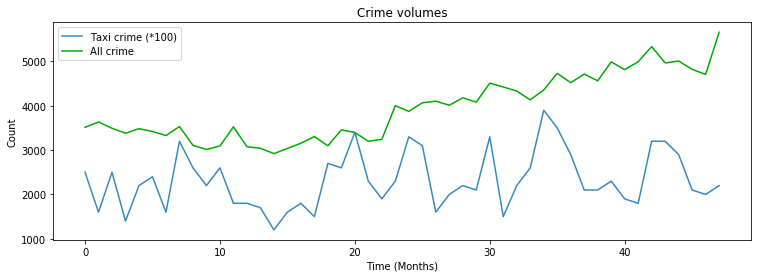

In [5]:
figsize(12.5, 4)
plt.plot(np.arange(len(date)), taxi_crime*100, color="#348ABD", label="Taxi crime (*100)")
plt.plot(np.arange(len(date)), all_crime, color="#00AA00", label="All crime")
plt.xlabel("Time (Months)")
plt.ylabel("Count")
plt.title("Crime volumes")
plt.legend()

As _all crime_ has much larger volumes than _taxi crime_, index to the first point and then calculate the difference. This will give them comparable sizes.

In [6]:
taxi_i = np.array( [ x /  taxi_crime[0]  for x in taxi_crime ] )
all_i  = np.array( [ x /  all_crime[0]  for x in all_crime ] )
diff = all_i - taxi_i

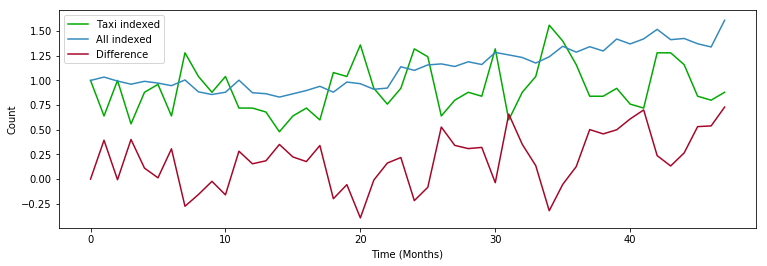

In [7]:
figsize(12.5, 4)
plt.plot(np.arange(len(date)), taxi_i, color="#00AA00", label="Taxi indexed")
plt.plot(np.arange(len(date)), all_i, color="#348ABD", label="All indexed")
plt.plot(np.arange(len(date)), diff, color="#A60628", label="Difference")
plt.xlabel("Time (Months)")
plt.ylabel("Count")
plt.legend()

It doesn't work very well using these noisy data. So try calculating the difference between the two proportions as a 12-month rolling average

In [8]:
avg_diff = []
avg_taxi = []
avg_all = []
for i in range(12, len(taxi_i)):
    taxi_mean =  np.mean(taxi_i[i-12:i])
    all_mean =  np.mean(all_i[i-12:i])
    avg_taxi.append(taxi_mean)
    avg_all.append(all_mean)
    avg_diff.append(all_mean - taxi_mean)

avg_diff = np.array(avg_diff)
avg_taxi = np.array(avg_taxi)
avg_all  = np.array(avg_all)

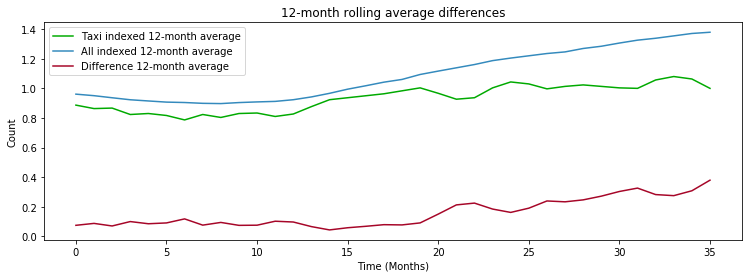

In [9]:
figsize(12.5, 4)
plt.plot(np.arange(len(avg_diff)), avg_taxi, color="#00AA00", label="Taxi indexed 12-month average")
plt.plot(np.arange(len(avg_diff)), avg_all, color="#348ABD", label="All indexed 12-month average")
plt.plot(np.arange(len(avg_diff)), avg_diff, color="#A60628", label="Difference 12-month average")
plt.xlabel("Time (Months)")
plt.ylabel("Count")
plt.title("12-month rolling average differences")
plt.legend()

## Model Conception

We want to model the difference between the two indexed crime volumes. The difference is continuous and could be positive or negative. Therefore lets assume that the difference can be modelled using a normal distribution:

$$X \sim N(\mu, 1/\tau)$$

The values of $\mu$ and $\tau$ determine the shape of the distribution. The $\tau$ will give us information about the spread of the difference. $\mu$ is especially useful: a _larger_ value for $\mu$ will higher probability of _larger_ variable values being chosen. Therefore if a model suggests that $\mu$ increases after some point (i.e. the introduction of the Deregulation Act) then it would appear that the differnce has increased.

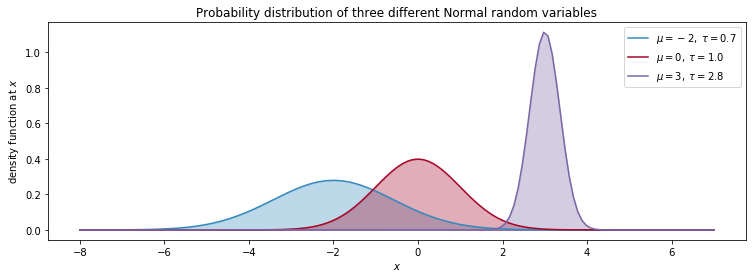

In [10]:

nor = stats.norm
x = np.linspace(-8, 7, 150)
mu = (-2, 0, 3)
tau = (.7, 1, 2.8)
colors = ["#348ABD", "#A60628", "#7A68A6"]
parameters = zip(mu, tau, colors)

for _mu, _tau, _color in parameters:
    plt.plot(x, nor.pdf(x, _mu, scale=1./_tau),
             label="$\mu = %d,\;\\tau = %.1f$" % (_mu, _tau), color=_color)
    plt.fill_between(x, nor.pdf(x, _mu, scale=1./_tau), color=_color,
                     alpha=.33)

plt.legend(loc="upper right")
plt.xlabel("$x$")
plt.ylabel("density function at $x$")
plt.title("Probability distribution of three different Normal random \
variables");

We want to test whether at some point (e.g. at the introduction of the Deregulation Act) the difference in crime volumes changed. Call this point $z$. After $z$, the difference suddenly becomes larger; $\mu$ increases. Therefore there are two $\mu$ parameters, one before $z$ and one after (and each will have its own $\tau$ parameter):

$$
X \sim N
\begin{cases}
    (\mu_1, 1/\tau_1 ) & \text{if } t \lt z \cr
    (\mu_2, 1/\tau_2 ) & \text{if } t \ge z
\end{cases}
$$

If, in reality, no sudden change occurred and indeed $\mu_1 = \mu_2$, then the $\mu$s posterior distributions should look about equal.


We are interested in inferring the unknown $\mu$s and $\tau$s. To use Bayesian inference, we need to assign prior probabilities to their different possible values. $\mu$ is continuous and might be negative (this would happen if taxi crime were more abundant than all other crime), so use a normal distrubtion again. $\tau$ is also continuous, but cannot be negative, so use an exponential distribution.  Each of those distributions has their own parameters, so we now have six _hyper-parameters_ (two for each of the $\mu$s and one for each $\tau$). Name them $\alpha$, $\beta$ and $\gamma$:

$$
\begin{align}
& \mu_1 \sim \text{N} (\alpha_1, 1/\beta_1) \text{ , } \tau_1 \sim \text{Exp} (\gamma_1) \\\
& \mu_2 \sim \text{N} (\alpha_2, 1/\beta_2) \text{ , } \tau_2 \sim \text{Exp} (\gamma_2)
\end{align}
$$

The $\alpha$, $\beta$ and $\gamma$ parameters influence other parameters, so our initial guesses do not influence the model too strongly, so we have some flexibility in our choice.  

We also need a distribution for the point at which the difference changes ($z$). Assign a *uniform prior belief* to every possible time point. This will reduce any personal bias. 

\begin{align}
& z \sim \text{DiscreteUniform(1,N) }\\\\
& \Rightarrow P( \tau = k ) = \frac{1}{N}
\end{align}

where $N$ is the number of time points in the data.

## Model Definition

Now define the model using PYMC. (_Note that we use the same values for the hyperparameters, although above I talked about them as separate variables for each of the two Normal distributions_).

In [11]:

with pm.Model() as model:
    # The hyperparameters
    alpha = 1.0
    beta = 1.0
    gamma = 1.0/avg_diff.mean()
    
    # The two mean and sd variables parameters.
    # (We want to see if their posterior distributions change)
    mu_1 = pm.Normal("mu_1", mu = alpha, tau = beta)
    mu_2 = pm.Normal("mu_2", mu = alpha, tau = beta)
    
    tau_1 = pm.Exponential("tau_1", gamma)
    tau_2 = pm.Exponential("tau_2", gamma)
    #taus = pm.Exponential("taus", gamma, shape=2)

    # Z is the point at which the texting behaviour changed. 
    # Don't know anything about this so assign a uniform prior belief
    z = pm.DiscreteUniform("z", lower=0, upper=len(avg_diff) - 1)
    
    # Creates new functions using switch() to assign the correct mu or tau variables
    # These can be thought of as the random variables mu and tau definied initially.
    idx = np.arange(len(avg_diff)) # Index
    mu_ =  pm.math.switch(z > idx, mu_1, mu_2)
    tau_ = pm.math.switch(z > idx, tau_1, tau_2)
    
    # Combine the observation data (we assume that it has been generated by
    # a normal distribution with our mu and tau parameters).
    obs = pm.Normal("obs", mu=mu_, tau=tau_, observed=avg_diff)

The model has been defined, now we can perform MCMC to sample from the posterior distribution

In [12]:
N = 5000 # Number of samples
with model:
    step = pm.Metropolis()
    start = pm.find_MAP() # Help it to start from a good place
    trace = pm.sample(N, tune=int(N*2), step=step, start=start, njobs=4)

logp = -47.479, ||grad|| = 0.19387: 100%|██████████| 17/17 [00:00<00:00, 1129.13it/s] 
100%|██████████| 15000/15000 [00:13<00:00, 1083.95it/s]


The model has finished. Now example our samples

In [13]:
mu_1_samples = trace['mu_1']
mu_2_samples = trace['mu_1']
tau_1_samples = trace['tau_1']
tau_2_samples = trace['tau_2']
z_samples = trace['z']

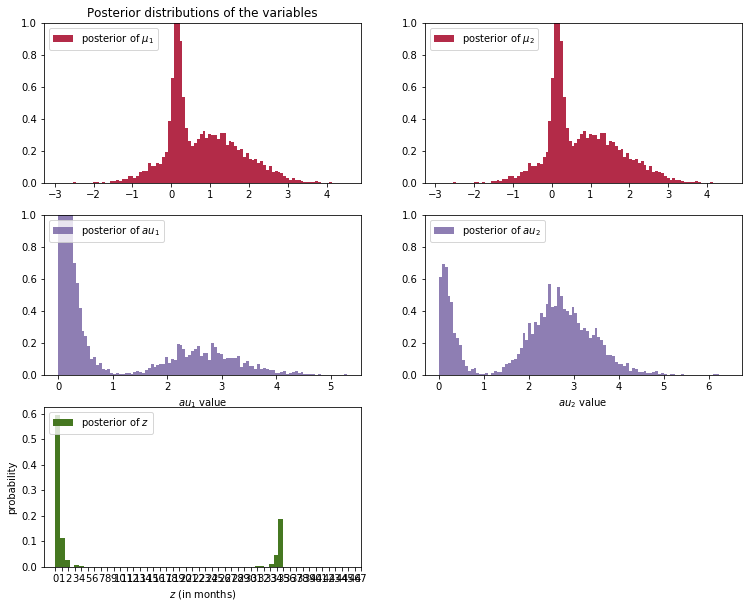

In [14]:
figsize(12.5, 10)
#histogram of the samples:

# MUs

ax = plt.subplot(321) # rows, columns, index
ax.set_autoscaley_on(False)
plt.hist(mu_1_samples, histtype='stepfilled', bins=100, alpha=0.85,
         label="posterior of $\mu_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables""")
#plt.xlim([15, 30])
#plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(322) # rows, columns, index
ax.set_autoscaley_on(False)
plt.hist(mu_2_samples, histtype='stepfilled', bins=100, alpha=0.85,
         label="posterior of $\mu_2$", color="#A60628", normed=True)
plt.legend(loc="upper left")
#plt.xlim([15, 30])
#plt.xlabel("$\lambda_1$ value")


# TAUs

ax = plt.subplot(323)
ax.set_autoscaley_on(False)
plt.hist(tau_1_samples, histtype='stepfilled', bins=100, alpha=0.85,
         label="posterior of $\tau_1$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
#plt.xlim([15, 30])
plt.xlabel("$\tau_1$ value")

ax = plt.subplot(324)
ax.set_autoscaley_on(False)
plt.hist(tau_2_samples, histtype='stepfilled', bins=100, alpha=0.85,
         label="posterior of $\tau_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
#plt.xlim([15, 30])
plt.xlabel("$\tau_2$ value")


plt.subplot(325)
w = 1.0 / z_samples.shape[0] * np.ones_like(z_samples)
plt.hist(z_samples, bins=len(diff), alpha=1,
         label=r"posterior of $z$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(len(diff)))

plt.legend(loc="upper left")
#plt.ylim([0, .75])
#plt.xlim([35, len(dif)-20])
plt.xlabel(r"$z$ (in months)")
plt.ylabel("probability");

Some more diagnostic visualisations

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126195a58>,
      dtype=object)

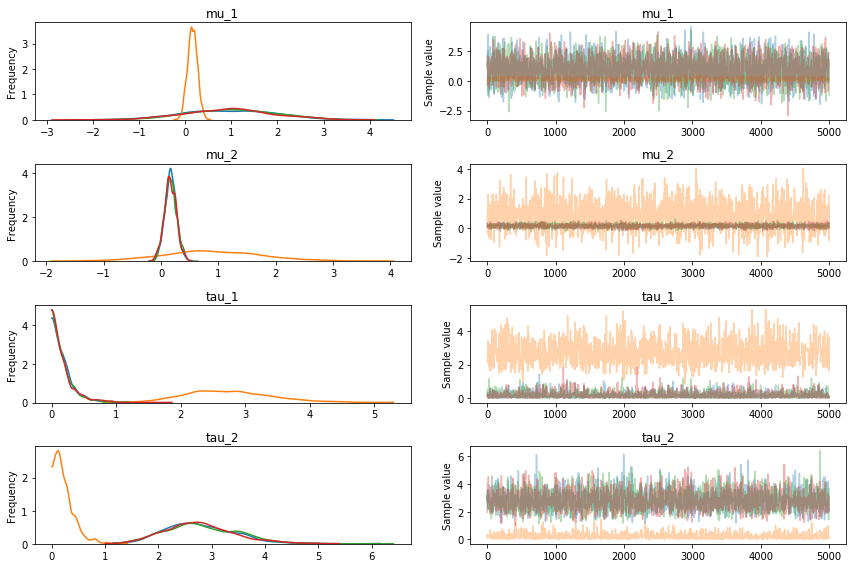

In [15]:
pm.plots.traceplot(trace=trace, varnames=["mu_1", "mu_2", "tau_1", "tau_2"])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12fda1f60>,
      dtype=object)

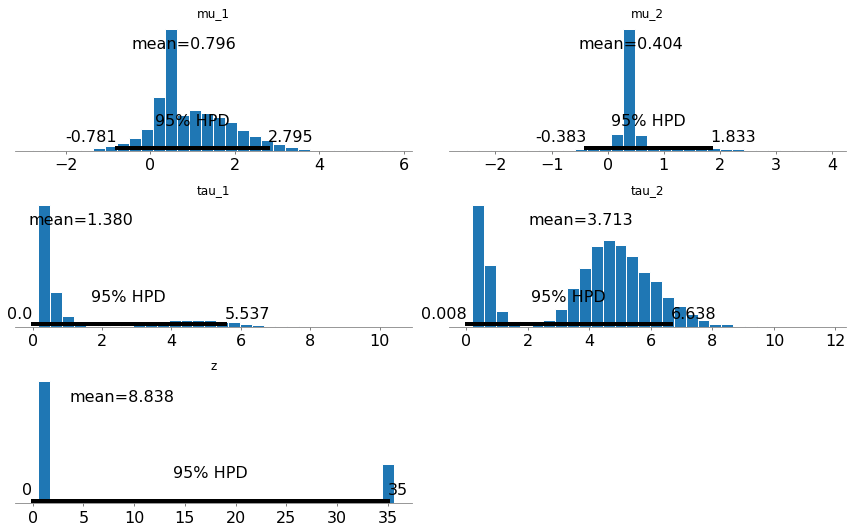

In [77]:
pm.plots.plot_posterior(trace=trace, varnames=["mu_1", "mu_2", "tau_1", "tau_2", "z"])
#pm.plots.plot_posterior(trace=trace["centers"][:,1])
#pm.plots.autocorrplot(trace=trace, varnames=["centers"]);

## Next steps:

Think about How to detect structural change in a timeseries.

E.g.: [https://stats.stackexchange.com/questions/16953/how-to-detect-structural-change-in-a-timeseries]
    
    Can involve Jose too.